In [15]:
import os
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
import copy

# Definir las rutas
base_path = 'DATASET'
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')
# Verificar si las carpetas existen
if not os.path.exists(train_dir):
    print(f"error: La carpeta de entrenamiento '{train_dir}' no existe.")
if not os.path.exists(test_dir):
    print(f"error: La carpeta de testeo '{test_dir}' no existe.")
# Definir las rutas de las subcarpetas
# de imágenes normales y con tumor
train_normal = os.path.join(train_dir, 'normal')
train_tumor = os.path.join(train_dir, 'pancreatic_tumor')
test_normal = os.path.join(test_dir, 'normal')
test_tumor = os.path.join(test_dir, 'pancreatic_tumor')

# Contar el número de imágenes en cada carpeta
print("Cantidad de imágenes en entrenamiento:")
print("Normal:", len(os.listdir(train_normal)))
print("Tumor pancreático:", len(os.listdir(train_tumor)))

#print("Cantidad de imágenes en testeo:")
#print("Normal:", len(os.listdir(test_normal)))
#print("Tumor pancreático:", len(os.listdir(test_tumor)))

total_train = len(os.listdir(train_normal)) + len(os.listdir(train_tumor))
#total_test = len(os.listdir(test_normal)) + len(os.listdir(test_tumor))

print("Total imágenes entrenamiento:", total_train)
#print("Total imágenes testeo:", total_test)

error: La carpeta de testeo 'DATASET\test' no existe.
Cantidad de imágenes en entrenamiento:
Normal: 423
Tumor pancreático: 578
Total imágenes entrenamiento: 1001


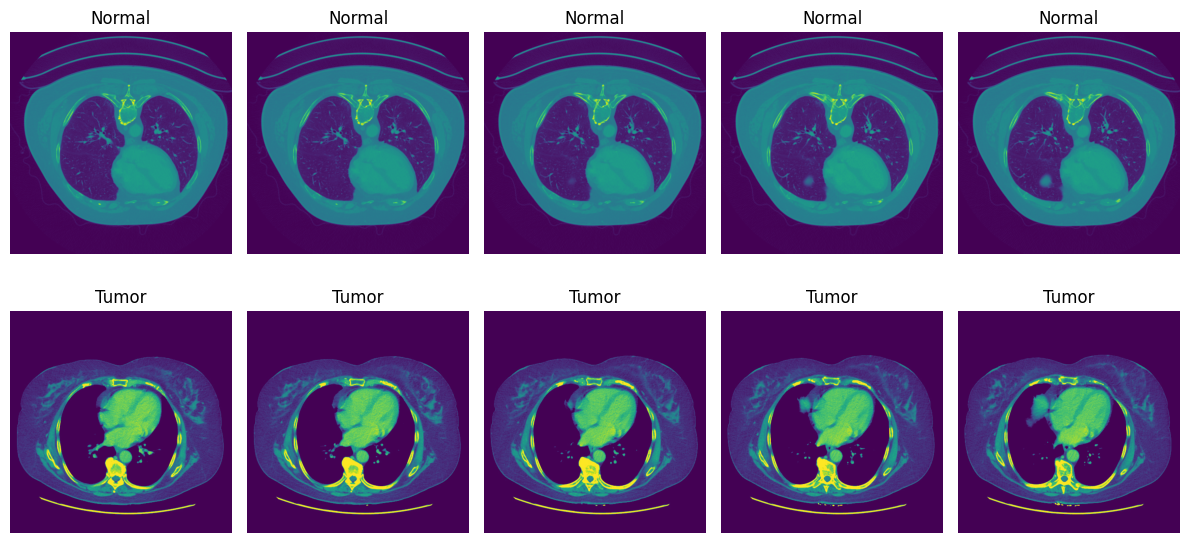

In [16]:
# Mostrar algunas imágenes de entrenamiento
plt.figure(figsize=(12, 6)) 
# Mostrar imágenes normales
normal_imagenes = glob(os.path.join(train_normal, '*.jpg'))[:5]
for i, img_path in enumerate(normal_imagenes):
    img = mpimg.imread(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Normal')
# Mostrar imágenes con tumor
tumor_imagenes = glob(os.path.join(train_tumor, '*.jpg'))[:5]
for i, img_path in enumerate(tumor_imagenes):
    img = mpimg.imread(img_path)
    plt.subplot(2, 5, i + 6)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Tumor')
plt.tight_layout()
plt.show()

In [17]:
def imagen_valida(ruta):
    try:
        with Image.open(ruta) as img:
            img.verify()
        return True
    except:
        return False

# Encontrar duplicados entre train y test
train_files = set(os.listdir(train_normal)) | set(os.listdir(train_tumor))
#test_files = set(os.listdir(test_normal)) | set(os.listdir(test_tumor))
#duplicados = train_files & test_files

# Curar una carpeta eliminando imágenes no válidas y duplicadas
def curar_carpeta(carpeta, duplicados_set):
    errores = []
    for archivo in os.listdir(carpeta):
        ruta = os.path.join(carpeta, archivo)
        # Eliminar si no es válida
        if not imagen_valida(ruta):
            errores.append(ruta)
            os.remove(ruta)
        # Eliminar si es duplicado y está en test
        elif carpeta in [test_normal, test_tumor] and archivo in duplicados_set:
            errores.append(ruta + " (duplicada)")
            os.remove(ruta)
    return errores

carpetas = [train_normal, train_tumor, test_normal, test_tumor]
errores = []

#for folder in carpetas:
    #errores += curar_carpeta(folder, duplicados)

print("Imagenes eliminadas o duplicadas:")
for e in errores:
    print(e)

Imagenes eliminadas o duplicadas:


In [18]:
#creo la funcion del cnn
class CNN_simple(nn.Module):
    def __init__(self):
        super(CNN_simple, self).__init__()
        # Usar nn.Sequential para agrupar las capas
        self.conv_layers = nn.Sequential(
            # Bloque 1
            nn.Conv2d(3, 16, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x128 -> 64x64

            # Bloque 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x64 -> 32x32

            # Bloque 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 32x32 -> 16x16
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            # LazyLinear calculará automáticamente el tamaño de entrada (64 * 16 * 16)
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Verificar si hay GPU disponible y mover el modelo a la GPU si es posible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Crear una instancia del modelo y moverlo al dispositivo
model = CNN_simple().to(device) 
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
          Flatten-10                [-1, 50176]               0
           Linear-11                  [-1, 128]       6,422,656
             ReLU-12                  [-1, 128]               0
           Linear-13                    [-1, 2]             258
Total params: 6,446,498
Trainable param

In [19]:
fun_de = nn.CrossEntropyLoss() # definir la función de pérdida
# definir el optimizador
# usar Adam como optimizador con una tasa de aprendizaje de 0.001
optimizar = optim.Adam(model.parameters(), lr=0.001)
# definir las transformaciones para los datos de entrenamiento y prueba

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # redimensionar las imágenes a 128x128
    transforms.ToTensor(), # convertir las imágenes a tensores de PyTorch
    transforms.Normalize([0.5]*3, [0.5]*3) # normalizar las imágenes 
])

# cargar los conjuntos de datos de entrenamiento 
train_dataset = datasets.ImageFolder(train_dir, transform=transform)

# crear los DataLoaders para cargar los datos en lotes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
lista_perdidas = []  # lista para almacenar las pérdidas por epoca
# entrenar el modelo
num_epoca = 10  # numero de epocas de entrenamiento
for epoch in range(num_epoca):
    model.train()  # poner el modelo en modo de entrenamiento
    perdida_acumu = 0.0  # iniciar la pérdida acumulada
    for imagenes, labels in train_loader:
        imagenes, labels = imagenes.to(device), labels.to(device)  # mover los datos al dispositivo
        optimizar.zero_grad()  # limpiar los gradientes del optimizador
        outputs = model(imagenes)  # pasar las imagenes a traves del modelo
        perdida = fun_de(outputs, labels)  # calcular la perdida
        perdida.backward()  # calcular los gradientes
        optimizar.step()  # actualizar los pesos del modelo
        perdida_acumu += perdida.item() * imagenes.size(0)  # acumular la perdida

    epoca_perdida = perdida_acumu / len(train_dataset)  # calcular la pérdida promedio por epoca
    lista_perdidas.append(epoca_perdida)  # almacenar la pérdida de la epoca
    print(f"Epoca [{epoch + 1}/{num_epoca}], Loss: {epoca_perdida:.4f}")
torch.save(model.state_dict(), "cnn_model.pth")

Epoca [1/10], Loss: 0.2130
Epoca [2/10], Loss: 0.0525
Epoca [3/10], Loss: 0.0392
Epoca [4/10], Loss: 0.0308
Epoca [5/10], Loss: 0.0482
Epoca [6/10], Loss: 0.0346
Epoca [7/10], Loss: 0.0422
Epoca [8/10], Loss: 0.0351
Epoca [9/10], Loss: 0.0287
Epoca [10/10], Loss: 0.0337


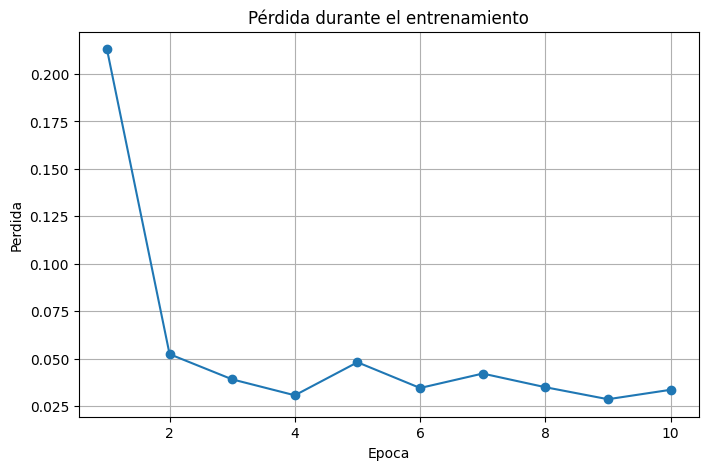

In [20]:
# Graficar la pérdida durante el entrenamiento
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epoca + 1), lista_perdidas, marker='o')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Epoca')
plt.ylabel('Perdida')
plt.grid(True)
plt.show()


In [21]:
#evaluar el modelo en el conjunto de prueba
model.eval()  # Poner el modelo en modo de evaluación
correct = 0  # Contador de aciertos
total = 0  # Contador total de imágenes
with torch.no_grad():  # Desactivar el cálculo de gradientes
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Mover los datos al dispositivo
        outputs = model(images)  # Pasar las imágenes a través del modelo
        _, predicted = torch.max(outputs, 1)  # Obtener las predicciones
        total += labels.size(0)  # Acumular el total de imágenes
        correct += (predicted == labels).sum().item()  # Contar los aciertos
accuracy = 100 * correct / total  # Calcular la precisión
print(f"Precisión del modelo: {accuracy:.2f}%")

Precisión del modelo: 98.20%


In [22]:
#data augmentation
# Definir las transformaciones
transform_train = transforms.Compose([
    transforms.Resize((224,224)), #poner las imagenes a 224x224
    transforms.RandomHorizontalFlip(), #poner un flip horizontal a las imagenes 
    transforms.RandomRotation(20), #rotar las imagenes 20 grados
    transforms.ColorJitter(brightness=0.2, contrast=0.2), #cambiar el brillo y contraste de las imagenes
    transforms.ToTensor(), #convertir las imagenes a tensores de PyTorch
    transforms.Normalize([0.5]*3, [0.5]*3) #normalizar las imagenes
])
# Transformación para validación (sin augmentación)
transform_val = transforms.Compose([
    transforms.Resize((224,224)), #redimensionar las imágenes a 224x224
    transforms.ToTensor(), #convertir las imágenes a tensores de PyTorch
])

# Dataset y DataLoaders con división en entrenamiento y validación
dataset = datasets.ImageFolder("dataset/train", transform=transform_train) #cargar el conjunto de datos con transformaciones de entrenamiento
# Dividir el dataset en entrenamiento y validación (80% - 20%)
val_size = int(0.2 * len(dataset)) #tamaño del conjunto de validación 
train_size = len(dataset) - val_size #tamaño del conjunto de entrenamiento
train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) #dividir el conjunto de datos en entrenamiento y validación

# Reemplazar transform de validación 
val_dataset.dataset.transform = transform_val
# Crear DataLoaders para entrenamiento y validación 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #cargar los datos de entrenamiento en lotes
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) #cargar los datos de validación en lotes

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_wts = None
        self.best_epoch = None
        self.verbose = verbose

    def __call__(self, val_loss, model, epoch):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.best_epoch = epoch
            self.counter = 0
            if self.verbose:
                print(f"Nuevo mejor modelo en epoch {epoch+1}, val_loss: {val_loss:.4f}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No mejora en epoch {epoch+1}. Paciencia: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping activado")

    def load_best_model(self, model):
        "Restaura el mejor modelo guardado"
        if self.best_model_wts is not None:
            model.load_state_dict(self.best_model_wts)
        return model



# Función para entrenar una época
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


# Función para validar el modelo
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


# Configuración del entrenamiento
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, verbose=True)

# Para guardar métricas
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Bucle de entrenamiento con early stopping
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    early_stopping(val_loss, model, epoch)
    if early_stopping.early_stop:
        print("Deteniendo el entrenamiento temprano")
        break

# restaurar el mejor modelo antes de evaluar
model = early_stopping.load_best_model(model)

Epoch [1/50] Train Loss: 0.1745, Train Acc: 0.9600 | Val Loss: 0.0591, Val Acc: 0.9800
 ✅ Nuevo mejor modelo en epoch 1, val_loss: 0.0591
Epoch [2/50] Train Loss: 0.0463, Train Acc: 0.9800 | Val Loss: 0.0411, Val Acc: 0.9800
 ✅ Nuevo mejor modelo en epoch 2, val_loss: 0.0411
Epoch [3/50] Train Loss: 0.0297, Train Acc: 0.9863 | Val Loss: 0.0403, Val Acc: 0.9800
 ✅ Nuevo mejor modelo en epoch 3, val_loss: 0.0403
Epoch [4/50] Train Loss: 0.0246, Train Acc: 0.9900 | Val Loss: 0.0780, Val Acc: 0.9650
 ⏳ No mejora en epoch 4. Paciencia: 1/5
Epoch [5/50] Train Loss: 0.0358, Train Acc: 0.9813 | Val Loss: 0.0551, Val Acc: 0.9750
 ⏳ No mejora en epoch 5. Paciencia: 2/5
Epoch [6/50] Train Loss: 0.0281, Train Acc: 0.9813 | Val Loss: 0.0507, Val Acc: 0.9750
 ⏳ No mejora en epoch 6. Paciencia: 3/5
Epoch [7/50] Train Loss: 0.0270, Train Acc: 0.9825 | Val Loss: 0.0421, Val Acc: 0.9750
 ⏳ No mejora en epoch 7. Paciencia: 4/5
Epoch [8/50] Train Loss: 0.0284, Train Acc: 0.9838 | Val Loss: 0.0427, Val Acc